## Training 

In [1]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
import pickle
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Loading data and embeddings
label_embeddings = pickle.load(open("Data/Embeddings/CIFAR/CIFAR_100_label_to_embedding_google_news.pk", "rb"))
train_x = np.load("vgg_16/train_x.npy").reshape((50000,-1))
train_y = np.load("vgg_16/train_y.npy")
test_x = np.load("vgg_16/test_x.npy").reshape((10000,-1))
test_y = np.load("vgg_16/test_y.npy")

In [3]:
#Convert train/test labels to embeddings
train_y_embeddings = np.zeros((50000, 300))
test_y_embeddings = np.zeros((10000, 300))

for i in range(train_y.shape[0]):
    train_y_embeddings[i] = label_embeddings[int(train_y[i][0])]

for i in range(test_y.shape[0]):
    test_y_embeddings[i] = label_embeddings[int(test_y[i][0])]

In [4]:
model = Sequential()

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(300))

model.compile(loss='mse', optimizer='adam', metrics=['cosine_proximity'])

In [5]:
epochs = 25
batch_size = 128

model.fit(train_x, train_y_embeddings, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y_embeddings))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 47us/step - loss: 0.0520 - cosine_proximity: -0.5012 - val_loss: 0.0249 - val_cosine_proximity: -0.5790
Epoch 2/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.0194 - cosine_proximity: -0.6821 - val_loss: 0.0216 - val_cosine_proximity: -0.6339
Epoch 3/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.0163 - cosine_proximity: -0.7381 - val_loss: 0.0204 - val_cosine_proximity: -0.6558
Epoch 4/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.0144 - cosine_proximity: -0.7718 - val_loss: 0.0198 - val_cosine_proximity: -0.6707
Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.0131 - cosine_proximity: -0.7938 - val_loss: 0.0191 - val_cosine_proximity: -0.6791
Epoch 6/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.0121 - cosine_proximity: -0.8106 - val_loss:

## Testing

In [6]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [7]:
pred_test_y = model.predict(test_x)

label_embeddings
label_embeddings_arr = np.zeros((100, 300))
for i in range(100):
    label_embeddings_arr[i] = label_embeddings[i]

In [8]:
#Top K Predictions
def pred_top_k(k=5, pred_test_y=pred_test_y, label_embeddings_arr=label_embeddings_arr):
    sim_table = cosine_similarity(pred_test_y, label_embeddings_arr)
    top_k_guesses = np.argpartition(sim_table,range(99-k+1,100),axis=1)[:,99-k+1:]
    return top_k_guesses


#Top prediction
sim_table = cosine_similarity(pred_test_y, label_embeddings_arr)
label_predictions = sim_table.argmax(axis=1)
label_predictions

k=5
top_k_guesses = pred_top_k(5)

In [9]:
#Accuracy
acc = np.sum((np.squeeze(test_y) == label_predictions)) / float(test_y.shape[0])
print("Accuracy: " + str(acc))

#Top k Accuracy

def acc(top_k=top_k_guesses, test_y=test_y):
    correct = 0
    for i in range(test_y.shape[0]):
        if np.squeeze(test_y)[i] in top_k[i]:
            correct += 1
    return correct/float(test_y.shape[0])

print("Top " + str(k) + " Accuracy: " + str(acc()))

Accuracy: 0.5206
Top 5 Accuracy: 0.6917


In [10]:
x = np.linspace(0,99,100) 
y=np.zeros(100)

for i in range(100):
    k = i+1
    top_k_guesses = pred_top_k(k)
    y[i] = acc(top_k_guesses, test_y)

Text(0.5, 1.0, 'Top K Accuracy')

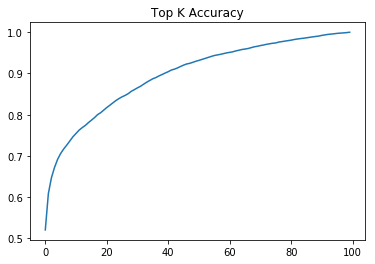

In [11]:
plt.plot(x,y)
plt.title("Top K Accuracy")